In [1]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
import os
import torchvision.models as models
import torchvision
# Define a transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by your model
    transforms.ToTensor(),          # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
])

In [2]:
dataset = datasets.ImageFolder(root='/home/hous/Desktop/LLAVA/data', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

In [3]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [4]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 11158
Validation dataset size: 2790


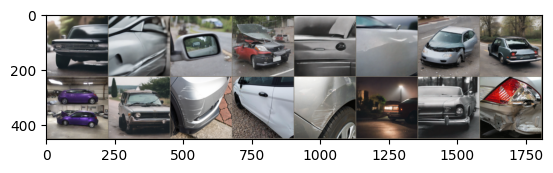

In [6]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)  # clip any values falling outside this range
    plt.imshow(img)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Make a grid from batch and show images
imshow(torchvision.utils.make_grid(images))

In [7]:
# Displaying distribution of labels in a batch
label_counts = {}
for _, labels in dataiter:
    for label in labels:
        label = label.item()
        label_counts[label] = label_counts.get(label, 0) + 1

print(label_counts)

{0: 5823, 1: 5319}


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class FFTResNet(nn.Module):
    def __init__(self, pretrained=True):
        super(FFTResNet, self).__init__()
        # Load a pretrained ResNet50 model
        self.resnet50 = models.resnet50(pretrained=pretrained)
        # Remove the last fully connected layer to get feature vector
        self.resnet50 = nn.Sequential(*(list(self.resnet50.children())[:-1]))

    def forward(self, x):
        # Apply FFT
        x = self.apply_fft(x)
        # Feature extraction with ResNet50
        features = self.resnet50(x)
        # Flatten the features
        return features.view(features.size(0), -1)

    def apply_fft(self, x):
        # Applying FFT
        x = torch.fft.fft2(torch.tensor(x, dtype=torch.complex64))
        # Shifting the zero frequency component to the center
        x = torch.fft.fftshift(x)
        # Taking the magnitude (abs) and applying log scale
        x = torch.log(torch.abs(x) + 1)
        # Normalizing and returning the real part
        return x.real

In [10]:
class CombinedResNet(nn.Module):
    def __init__(self, pretrained=True):
        super(CombinedResNet, self).__init__()

        # Standard ResNet50
        self.resnet50_standard = models.resnet50(pretrained=pretrained)
        self.resnet50_standard = nn.Sequential(*(list(self.resnet50_standard.children())[:-1]))

        # FFTResNet
        self.fft_resnet = FFTResNet(pretrained=pretrained)

        # Assuming both ResNet50 and FFTResNet output 2048-dimensional features
        combined_features_size = 2048 * 2  # Change accordingly if different

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(combined_features_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  
        )

    def forward(self, x):
        # Extract features from standard ResNet50
        features_standard = self.resnet50_standard(x).view(x.size(0), -1)

        # Extract features from FFTResNet
        features_fft = self.fft_resnet(x)

        # Concatenate the features from both streams
        combined_features = torch.cat((features_standard, features_fft), dim=1)

        # Classify using the combined features
        output = self.classifier(combined_features)
        return output

In [11]:
# Initialize the combined ResNet model
combined_resnet_model = CombinedResNet(pretrained=True)

/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hous/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_resnet_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [13]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()

        # Log the progress
        if batch_idx % 50 == 0:  # Adjust the logging frequency as needed
            print(f"Epoch [{epoch+1}/{num_epochs}] - Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / (len(dataloader.dataset))
    return avg_loss, accuracy

In [14]:
def validate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / (len(dataloader.dataset))
    return avg_loss, accuracy

In [15]:
num_epochs = 10  # Set the number of epochs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
combined_resnet_model.to(device)

# Check if a saved model checkpoint exists
checkpoint_path = 'best_combined_resnet_model.pth'
if os.path.isfile(checkpoint_path):
    combined_resnet_model.load_state_dict(torch.load(checkpoint_path))
    print("Loaded saved model checkpoint.")

best_val_accuracy = 0  # Initialize the best validation accuracy

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(combined_resnet_model, train_loader, criterion, optimizer, device, epoch, num_epochs)
    val_loss, val_accuracy = validate_model(combined_resnet_model, val_loader, criterion, device)
    
    # Update the learning rate
    scheduler.step()

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(combined_resnet_model.state_dict(), checkpoint_path)
        print("Improved validation accuracy! Model saved.")


Loaded saved model checkpoint.


/tmp/ipykernel_10630/3951468003.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.fft.fft2(torch.tensor(x, dtype=torch.complex64))


Epoch [1/10] - Batch 1/698 - Loss: 0.0474
Epoch [1/10] - Batch 51/698 - Loss: 0.0019
Epoch [1/10] - Batch 101/698 - Loss: 0.0033
Epoch [1/10] - Batch 151/698 - Loss: 0.1753
Epoch [1/10] - Batch 201/698 - Loss: 0.0531
Epoch [1/10] - Batch 251/698 - Loss: 0.2973
Epoch [1/10] - Batch 301/698 - Loss: 0.0199
Epoch [1/10] - Batch 351/698 - Loss: 0.5752
Epoch [1/10] - Batch 401/698 - Loss: 0.0964
Epoch [1/10] - Batch 451/698 - Loss: 0.2258
Epoch [1/10] - Batch 501/698 - Loss: 0.3085
Epoch [1/10] - Batch 551/698 - Loss: 0.1763
Epoch [1/10] - Batch 601/698 - Loss: 0.0416
Epoch [1/10] - Batch 651/698 - Loss: 0.0872
Epoch 1/10
Training Loss: 0.0845, Training Accuracy: 0.9719
Validation Loss: 0.7956, Validation Accuracy: 0.8613
Improved validation accuracy! Model saved.
Epoch [2/10] - Batch 1/698 - Loss: 0.0059
Epoch [2/10] - Batch 51/698 - Loss: 0.0062
Epoch [2/10] - Batch 101/698 - Loss: 0.0570
Epoch [2/10] - Batch 151/698 - Loss: 0.0440
Epoch [2/10] - Batch 201/698 - Loss: 0.0128
Epoch [2/10] -